In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
problem = "Pendulum-v1"
env = gym.make(problem)

# This is needed to get the input size for the NN
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

# This is needed to clip the actions within the legal boundaries
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

DeprecatedEnv: Env Pendulum-v1 not found (valid versions include ['Pendulum-v0'])

In [3]:
# This is a noise used in the paper that introduced DDPG https://arxiv.org/pdf/1509.02971v6.pdf
# From what I understand, we can also use Gaussian or other noise without much difference,
# I left the noise as is
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        # Its important to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

In [5]:
def get_actor(layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
class Agent:
    def __init__(self, buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(layer1=400, layer2=300)
        self.critic_model = get_critic(layer1=400, layer2=300)

        self.target_actor = get_actor(layer1=400, layer2=300)
        self.target_critic = get_critic(layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.buffer = Buffer(buffer_capacity, batch_size)
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.buffer.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.buffer.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.buffer.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.buffer.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object, use_noise=True):
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

            return [np.squeeze(legal_action)]

In [7]:
# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [8]:
def run(total_trials=3, total_episodes=100):
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])

        agent = Agent(buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
                actor_lr=0.001, gamma=0.99, tau=0.005)

        for ep in range(total_episodes):

            prev_state = env.reset()
            episodic_reward = 0

            while True:
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                action = agent.policy(tf_prev_state, agent.ou_noise)
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)

                agent.buffer.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)

            # Mean of last 40 episodes
            avg_reward = np.mean(ep_reward_list[trial][-40:])
            print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
            avg_reward_list[trial].append(avg_reward)

    # Plotting graph
    for idx, p in enumerate(avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("Avg. Epsiodic Reward (40)")
    plt.legend()
    plt.show()

Episode * 0 * Avg Reward is ==> -1456.7150368016746
Episode * 1 * Avg Reward is ==> -1463.8021019801506
Episode * 2 * Avg Reward is ==> -1524.2428655976962
Episode * 3 * Avg Reward is ==> -1549.7448027472105
Episode * 4 * Avg Reward is ==> -1556.9248211955774
Episode * 5 * Avg Reward is ==> -1512.5953420076414
Episode * 6 * Avg Reward is ==> -1504.9309471286494
Episode * 7 * Avg Reward is ==> -1490.5851117549628
Episode * 8 * Avg Reward is ==> -1425.4078258601203
Episode * 9 * Avg Reward is ==> -1376.126714739337
Episode * 10 * Avg Reward is ==> -1335.4688790590865
Episode * 11 * Avg Reward is ==> -1292.2108127963809
Episode * 12 * Avg Reward is ==> -1213.1411904579531
Episode * 13 * Avg Reward is ==> -1147.175007931117
Episode * 14 * Avg Reward is ==> -1079.6168746693288
Episode * 15 * Avg Reward is ==> -1029.2663365981043
Episode * 16 * Avg Reward is ==> -996.0353914900079
Episode * 17 * Avg Reward is ==> -940.8629825679423
Episode * 18 * Avg Reward is ==> -898.1130356661149
Episode 

Episode * 57 * Avg Reward is ==> -281.2275102837278
Episode * 58 * Avg Reward is ==> -283.9490655421572
Episode * 59 * Avg Reward is ==> -280.38950017439294
Episode * 60 * Avg Reward is ==> -283.0168413478002
Episode * 61 * Avg Reward is ==> -279.5729767934632
Episode * 62 * Avg Reward is ==> -285.8687218300082
Episode * 63 * Avg Reward is ==> -291.8216243736365
Episode * 64 * Avg Reward is ==> -294.80490327893847
Episode * 65 * Avg Reward is ==> -297.9251956450396
Episode * 66 * Avg Reward is ==> -295.1047869147807
Episode * 67 * Avg Reward is ==> -298.2409671167654
Episode * 68 * Avg Reward is ==> -300.4153384644511
Episode * 69 * Avg Reward is ==> -300.47945107628414
Episode * 70 * Avg Reward is ==> -300.05110186974235
Episode * 71 * Avg Reward is ==> -303.2703673080591
Episode * 72 * Avg Reward is ==> -303.21204142392224
Episode * 73 * Avg Reward is ==> -318.7077309862504
Episode * 74 * Avg Reward is ==> -312.59712522648226
Episode * 75 * Avg Reward is ==> -315.62914902364923
Episo

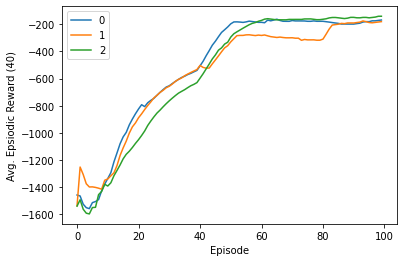

In [9]:
run()